In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Navegación Robot

- 0: ADELANTE
- 1: GIRAR A LA DERECHA
- 2: GIRAR A LA IZQUIERDA

## Local instalation (option 1)

Install the following Python packages to run this notebook

`pip install pip -U`

`pip install tensorflow jupyter`

## Google Colab (option 2)

[Google Colab](https://colab.research.google.com/) is a research project created to help disseminate machine learning education and research. It's a `Jupyter notebook` environment that requires no setup to use and runs entirely in the cloud.

Colaboratory notebooks are stored in [Google Drive](https://drive.google.com) and can be shared just as you would with Google Docs or Sheets. Colaboratory is free to use.

For more information, see our [FAQ](https://research.google.com/colaboratory/faq.html).

### How install extra packages
Google Colab installs a series of basic packages if we need any additional package just install it.

In [2]:
!pip install -q keras sklearn

!pip install shap

     |████████████████████████████████| 358kB 5.6MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491623 sha256=336d89554e98d793c6238ec8ef2001ad6a3f4ce1976769b1cf49a8b8d77d8eb8
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


## Import packages

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import collections

import sklearn
from sklearn.model_selection import train_test_split
from sklearn import metrics

import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow import keras
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.utils import class_weight

from sklearn.model_selection import KFold, StratifiedKFold

from keras.preprocessing.image import ImageDataGenerator

from scipy.stats import wilcoxon
import warnings
warnings.filterwarnings('ignore')
import shap

from skimage import data, img_as_float, exposure

In [4]:
print("Versión de Tensorflow: " + tf.__version__)
print("Versión de Keras: " + keras.__version__)

Versión de Tensorflow: 2.4.1
Versión de Keras: 2.4.0


## Define global constants

Lets start with a few epochs to test learning network parameters

In [5]:
batch_size = 32
nb_classes = 3
epochs = 6


## Build LeNet5 structure

<center><img src="https://www.dlsi.ua.es/~juanra/UA/curso_verano_DL/images/LeNet5.jpg"></center>

Building the model:

**(Mejor hasta el momento)** -> Funciones de activación ReLU

**Modelo inicial:**

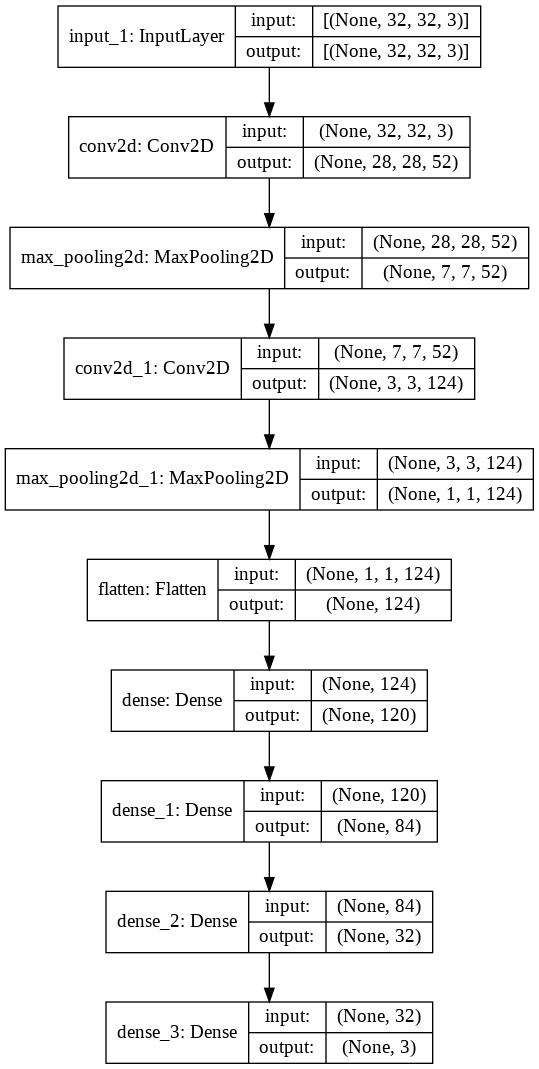

In [6]:
#Funciones de optimización probadas: sigmoid, tanh, relu, selu
#Mejor hasta el momento: relu
activation = "relu"


def cnn_model():
    #
    # Neural Network Structure
    #
    
    input_shape = (32, 32, 3)

    inputs = keras.Input(shape=input_shape)
    
    x = layers.Conv2D(52, (5, 5), activation=activation)(inputs)
    x = layers.MaxPooling2D(pool_size=(4, 4))(x)

    x = layers.Conv2D(124, (5, 5), activation=activation)(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.Flatten()(x)

    x = layers.Dense(120, activation=activation)(x)
    x = layers.Dense(84, activation=activation)(x)
    x = layers.Dense(32, activation=activation)(x)
    

    outputs = layers.Dense(nb_classes, activation='softmax')(x)

    model = keras.Model(inputs=inputs, outputs=outputs)

    return model


model = cnn_model()
keras.utils.plot_model(model, 'my_first_model_with_shape_info.png', show_shapes=True)

## Start to run the program

In [7]:
datagen = ImageDataGenerator(
  rescale=1./255
)

inputs = datagen.flow_from_directory(
    "/content/drive/MyDrive/datasets/esquivar_var",
    target_size=(32, 32),
    batch_size=batch_size,
    class_mode="categorical" 
)

Found 2398 images belonging to 3 classes.


In [8]:
model = cnn_model()

model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])
#early_stopping = EarlyStopping(monitor='val_loss', patience=8)
early_stopping = EarlyStopping(monitor='accuracy', patience=4)



#model.fit(datagen.flow(inputs_train, targets_train_nn, batch_size=24), verbose=2, epochs=10)
model.fit(inputs, epochs=epochs, batch_size=batch_size ,verbose=2, callbacks=early_stopping)

  
print(model.summary())

Epoch 1/6
75/75 - 1354s - loss: 0.3517 - accuracy: 0.8837
Epoch 2/6
75/75 - 15s - loss: 0.0381 - accuracy: 0.9875
Epoch 3/6
75/75 - 15s - loss: 0.0031 - accuracy: 1.0000
Epoch 4/6
75/75 - 15s - loss: 7.5071e-04 - accuracy: 1.0000
Epoch 5/6
75/75 - 15s - loss: 4.2066e-04 - accuracy: 1.0000
Epoch 6/6
75/75 - 15s - loss: 2.5030e-04 - accuracy: 1.0000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 52)        3952      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 52)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 124)         161324    
_______________________________________

#Guardar red

In [13]:
model.save('./modelo/modeloEsquivar.h5')
model.save_weights('./modelo/pesosEsquivar.h5')

In [10]:
def predict(file):
  x = load_img(file, target_size=(32, 32))
  x = img_to_array(x)
  x = np.expand_dims(x, axis=0)
  array = model.predict(x)
  result = array[0]
  answer = np.argmax(result)
  if answer == 0:
    print("pred: No Robot")
  elif answer == 1:
    print("pred: Robot a la derecha")
  elif answer == 2:
    print("pred: Robot a la izquierda")
  else:
    print("Extraño fallo")

  return answer

print()
print("No Robot:")
for i in range(10):
  print(predict("/content/drive/MyDrive/datasets/esquivar_var/no_robot/adelante000"+str(i)+".jpg"))

print()
print("Robot a la derecha:")
for i in range(1, 10):
  print(predict("/content/drive/MyDrive/datasets/esquivar_var/robot_derecha/robotderecha"+str(i)+".jpg"))

print()
print("Robot a la izquierda:")
for i in range(2, 10):
  print(predict("/content/drive/MyDrive/datasets/esquivar_var/robot_izquierda/robotizquierda"+str(i)+".jpg"))




No Robot:
pred: No Robot
0
pred: No Robot
0
pred: No Robot
0
pred: No Robot
0
pred: No Robot
0
pred: No Robot
0
pred: No Robot
0
pred: No Robot
0
pred: No Robot
0
pred: No Robot
0

Robot a la derecha:
pred: Robot a la derecha
1
pred: Robot a la derecha
1
pred: Robot a la derecha
1
pred: Robot a la derecha
1
pred: Robot a la derecha
1
pred: Robot a la derecha
1
pred: Robot a la derecha
1
pred: Robot a la derecha
1
pred: Robot a la derecha
1

Robot a la izquierda:
pred: Robot a la izquierda
2
pred: Robot a la izquierda
2
pred: Robot a la izquierda
2
pred: Robot a la izquierda
2
pred: Robot a la izquierda
2
pred: Robot a la izquierda
2
pred: Robot a la izquierda
2
pred: Robot a la izquierda
2
